## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import neighbors,tree, preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, recall_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [43]:
df = pd.read_csv('PetFinder_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Loading colour, breed and state labels:

In [44]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### Are the supposedly unique identifiers actually unique? What does it mean if they aren't?
PetID.

#### When data entries are blank, where does that come from?
The only blank entries in this dataset correspond to animal profiles without an assigned name.

#### How common are blank entries?
There are ~1200 blank entries, which constitute a significant portion of the data. Given this number, and due to the fact that blank entries have meaning attributed to them, it would perhaps be best to keep this data in the dataset for analysis.

## Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for AdoptionSpeed = 0. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

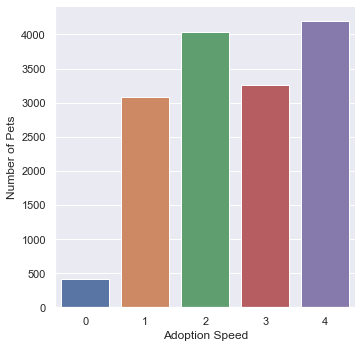

In [119]:
ax = sns.catplot(x="AdoptionSpeed",data=df, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

### Overall correlations
The plot bellow illustrates the absolute correlation between  each feature and the target class "AdoptionSpeed". All correlations are very low (<15%)

([<matplotlib.axis.XTick at 0x1a20d6e8d0>,
 <a list of 19 Text xticklabel objects>)

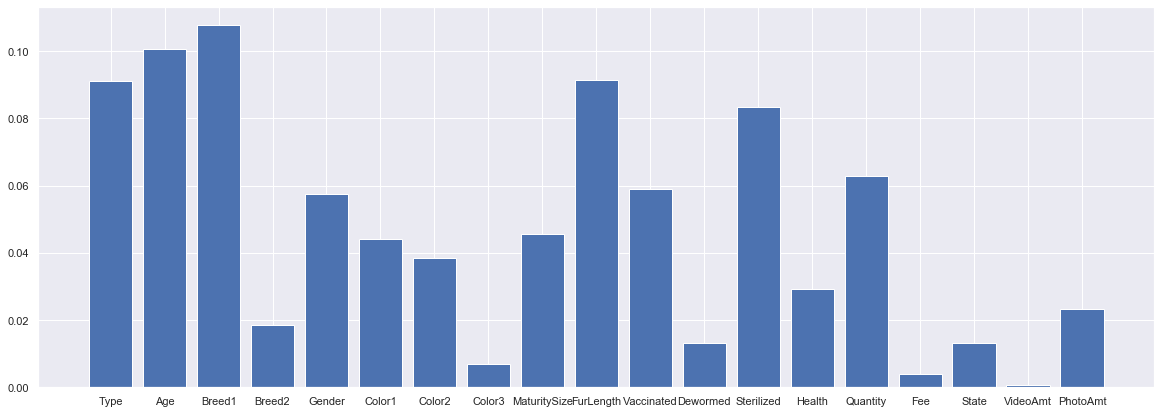

In [46]:
numeric_df = df.select_dtypes(exclude=['object'])
corr_dict = {}
for feature in numeric_df.columns:
    corr_dict[feature] = abs(df['AdoptionSpeed'].corr(df[feature]))
    #print(feature, '-->', corr_dict[feature])
    
corr_dict.pop('AdoptionSpeed')
plt.figure(figsize=(20,7))
plt.bar(range(len(corr_dict)), list(corr_dict.values()), align='center')
plt.xticks(range(len(corr_dict)), list(corr_dict.keys()))

### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

In [47]:
df.set_index("PetID", inplace=True) # change index to PetId
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,3.0,2


### Strategy

The following analysis was done to each feature:
* Check the number of examples for each feature values.
* Check the distribution of each feature values' among AdoptionSpeed classes.

For the second step we used the following visualisation method, which returns not only a plot on the distribution but also a table of representativity percentage gain of each feature's values for each AdoptionSpeed class, relatively to AdoptionSpeed=0:

In [48]:
# creates a stacked bar plot for any two categorical variables
# also creates a relative frequency version of the same plot
# and a relative gain compared to AdoptionSpeed=0 
# frel=False to return only the absolute frequency plot

def cat_distr_pairwise(cat_x,cat_y, df, frel):
    
    unique_cat_y = sorted(df[cat_y].unique())
    unique_cat_x = sorted(df[cat_x].unique())
    cat_count = pd.DataFrame(columns=unique_cat_y,index=unique_cat_x)
    for y in unique_cat_y:
        for x in unique_cat_x:
            count = df[cat_y][(df[cat_x]==x) & (df[cat_y]==y)].count()
            cat_count.at[x,y] = count 
    
    def color(val):
        if val < 0:
            color = 'red'
        elif val>0:
            color = 'green'
        else:
            color='white'
        return 'background-color: %s' % color
    
    if frel==False:
        
        #relative gain table
        relgain = cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))
        return cat_count.plot.bar(stacked=True, figsize=(10,7))
    
    else:
        #relative frequency stacked bar plot
        freq_cat_count = cat_count.divide(cat_count.sum(axis=1), axis=0)
        
        #relative gain table
        relgain = freq_cat_count.pct_change().cumsum() * 100
        print("Relative gain from AdoptionSpeed=0 (%):")
        display(relgain.style.applymap(color))

        return freq_cat_count.plot.bar(stacked=True, figsize=(10,7), title=cat_y + " relative distribution among AdoptionSpeed")
    

We will now present the most important conclusions taken from this analysis.

### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

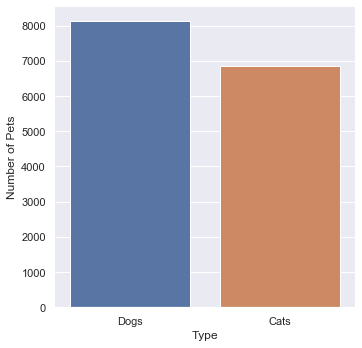

In [49]:
bx = sns.catplot(x="Type",data=df, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

Relative gain from AdoptionSpeed=0 (%):


,1,2
0,nan,nan
1,12.0027,-8.50189
2,27.429,-21.8776
3,38.9943,-35.2397
4,35.1712,-29.5518


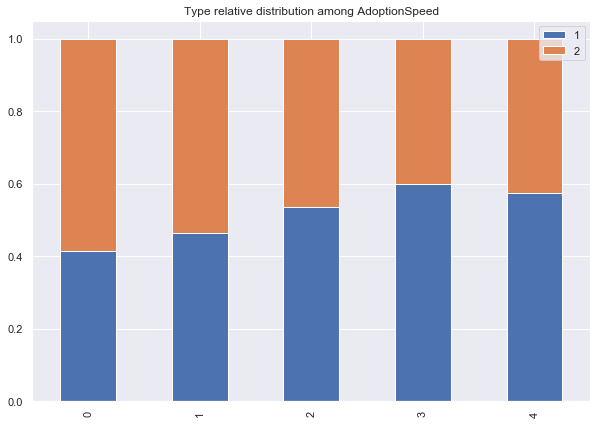

In [50]:
cat_distr_pairwise('AdoptionSpeed','Type', df, frel=True)

Looking at our data, the number of examples of dogs and cats is fairly proportional, as well as their relative distribution among target classes. 
Looking at the gain table, it is clear that dogs(1) tend to get adopted later relatively to cats(2),  which we can see by the growing relative gain. In fact, the number of dogs with no adoption after 100 days (adoptionSpeed=4) is 37% higher than dogs being adopted on the same day (adoptionSpeed=0). On the other hand, we observe the opposite phenomena on cats. They tend to be adopted at ealier stages, being the number of cats with no adoption after 100 days (adoptionSpeed=4) is 29% lower than cats being adopted on the same day (adoptionSpeed=0).
Despite this small discrepancies, we expect the resulting models' performance to be comparable.



### Name
Since a reasonable amount of the profiles didn't make any reference to name (empty) a first approach would be to fill those empty values with a fixed value such as "No Name" or similar.
Other approach would be to transform this feature into a binary one with a 0 value for profiles with no name and a 1 value for the opposite.
Since it was later found that some of the named profiles were filled with "No Name" and derivatives of this name such as "No Name Yet", "V6", "å°è±¹çº¹" etc., which are not proper names, we made an attempt to classify those cases as "No name" as well.

A glimpse on the ignored names: ['No Name Yet', 'No Name', 'No Name', 'H3', 'Z3', 'C', 'No Name', 'No Name', 'BB', 'QQ', 'Y1', 'No Name', 'H1', 'No Name Yet', 'D9', 'Y4', 'No Name', 'Z4', 'No Name', 'Unnamed', 'BB', 'DD', 'M2', 'H6', 'D4', 'QQ', 'JJ', 'No Names', 'å°\x8fè±¹çº¹', 'ä¼\x98ç¾\x8eå\x8f¯ç¬\x91', 'F1', 'æ©\x98å\xad\x90', 'W7', '(No Name)', 'No Name Yet', 'No Name', '1F', 'Q1', '6', 'CJ', '3F', '[No Name]', 'BB', 'KD', 'No Name Yet', 'No Name Yet', 'DD', 'No Name', 'G1', 'è\x8f\x9cè\x8f\x9cã\x80\x82']


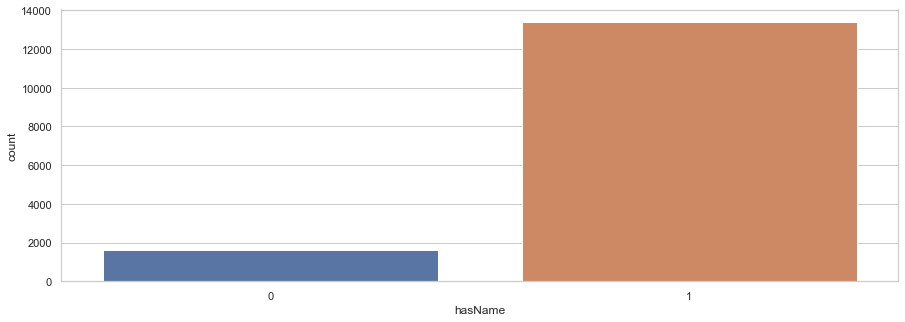

In [51]:
# Create new feature - hasNames
l = []
ignore = []

for i in df["Name"]:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        if len(i)<3: #Consider that a 2 letter name is not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("[a-zA-Z]", i) == None: #If name doesn't have letters, it's not a proper name.
            l.append(0)
            ignore.append(i)
        elif re.search("unnamed|no name",i, re.IGNORECASE) != None: 
            #If name string includes "unnamed" or "no name", it's not a proper name
            l.append(0)
            ignore.append(i)
        elif len(i.split())>0:
            l.append(1)

print("A glimpse on the ignored names:",ignore[:50])
df_processed1 = df.copy()
df_processed1.drop("Name", axis=1, inplace = True)
df_processed1.insert(1,"hasName",l) ##INSERT IN DATAFRAME

sns.set(style="whitegrid")
ax = sns.countplot(x="hasName", data=df_processed1)

Relative gain from AdoptionSpeed=0 (%):


,0,1
0,nan,nan
1,28.3828,-2.81545
2,14.3321,-0.974261
3,9.85559,-0.479193
4,38.1045,-3.44873


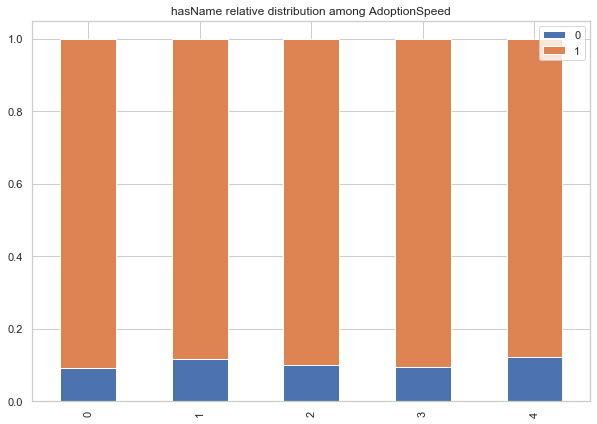

In [52]:
cat_distr_pairwise('AdoptionSpeed','hasName', df_processed1, frel=True)

As we can see from the plot above, the relative distribution of the "noName" feature values among "AdoptionSpeed" classes is very similar. This probabably means that the pet's name is not a very important factor in the adopter's decision.

### Age

When looking at the Age distribution, we can see that there are peaks every 12 months. Young pets (less than 1 year old) are the most frequent.

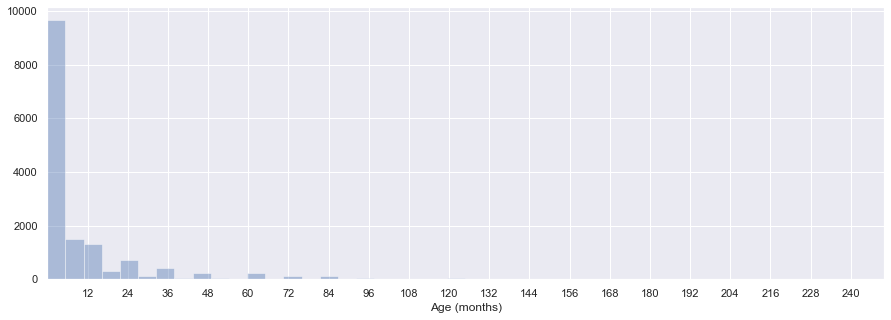

In [53]:
a = df['Age'] # get Age array
nr_bins = 1 + 3.322*math.log(len(a),2) # Number of bins according to Sturges rule
sns.set(rc={'figure.figsize':(15,5)}) # set figure size

# setting up the axis
fig, ax = plt.subplots()
ticks = [i for i in range(0,260,12)]
ticks.pop(0)
ax.set_xticks(ticks)
plt.xlim([0.0,250])

sns.distplot(a, bins=round(nr_bins), kde=False, axlabel="Age (months)");

The average cat is considered a kitten roughly until it reaches the age of 1 year old. The same goes for puppies. On the other hand, dogs and cats are considered Seniors roughly when they reach the age of 6 years. Of course, these are approximations, as the classification varies with the type of animal (cats or dogs), breed, size and many other factors.

In this sense, we will consider these categories:
* Baby - age 0-11 months => 0
* Adult - age 12-71 months =>1
* Senior - age 72-250 months =>2

In [54]:
# Create new feature - AgeGroup
AgeGroup = []
for i in df["Age"]:
    if i<12:
        AgeGroup.append(0)
    elif i<72:
        AgeGroup.append(1)
    else:
        AgeGroup.append(2)

df_processed2 = df_processed1.copy()
df_processed2.drop("Age", axis=1, inplace = True)
df_processed2.insert(2,"AgeGroup",AgeGroup) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1,2
0,nan,nan,nan
1,11.4206,-27.3511,-52.4542
2,11.9318,-35.1685,18.4303
3,7.09603,-14.0861,37.1413
4,-10.7473,54.0975,42.645


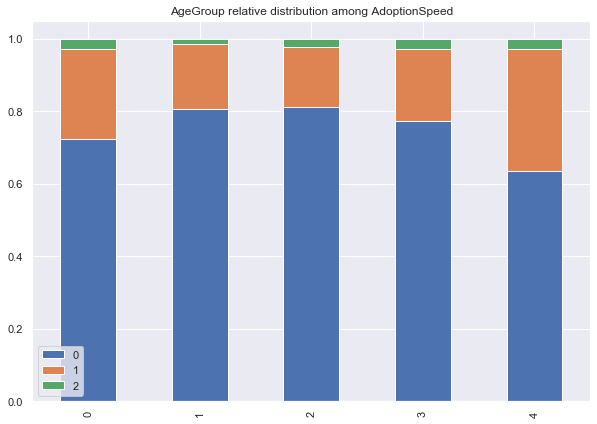

In [55]:
cat_distr_pairwise('AdoptionSpeed','AgeGroup', df_processed2, frel=True)

The relative distribution of AgeGroups among AdoptionSpeed indicates that there seems to be no particular correlation between being younger and getting adopted earlier. Even without the dicretization we can observe the same phenomena: 

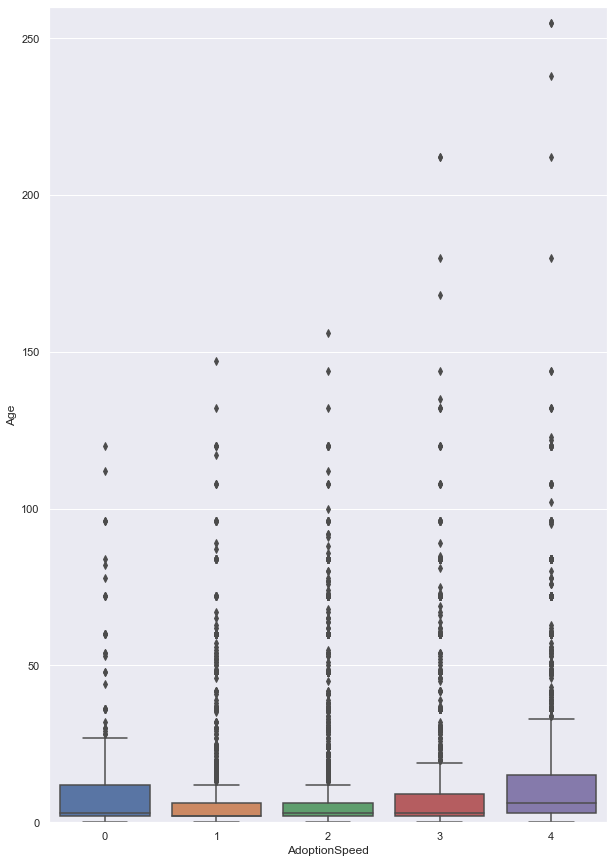

In [56]:
plt.figure(figsize=(10,15))
plt.ylim(0, 260)
sns.boxplot(data = df, x='AdoptionSpeed', y='Age')

### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

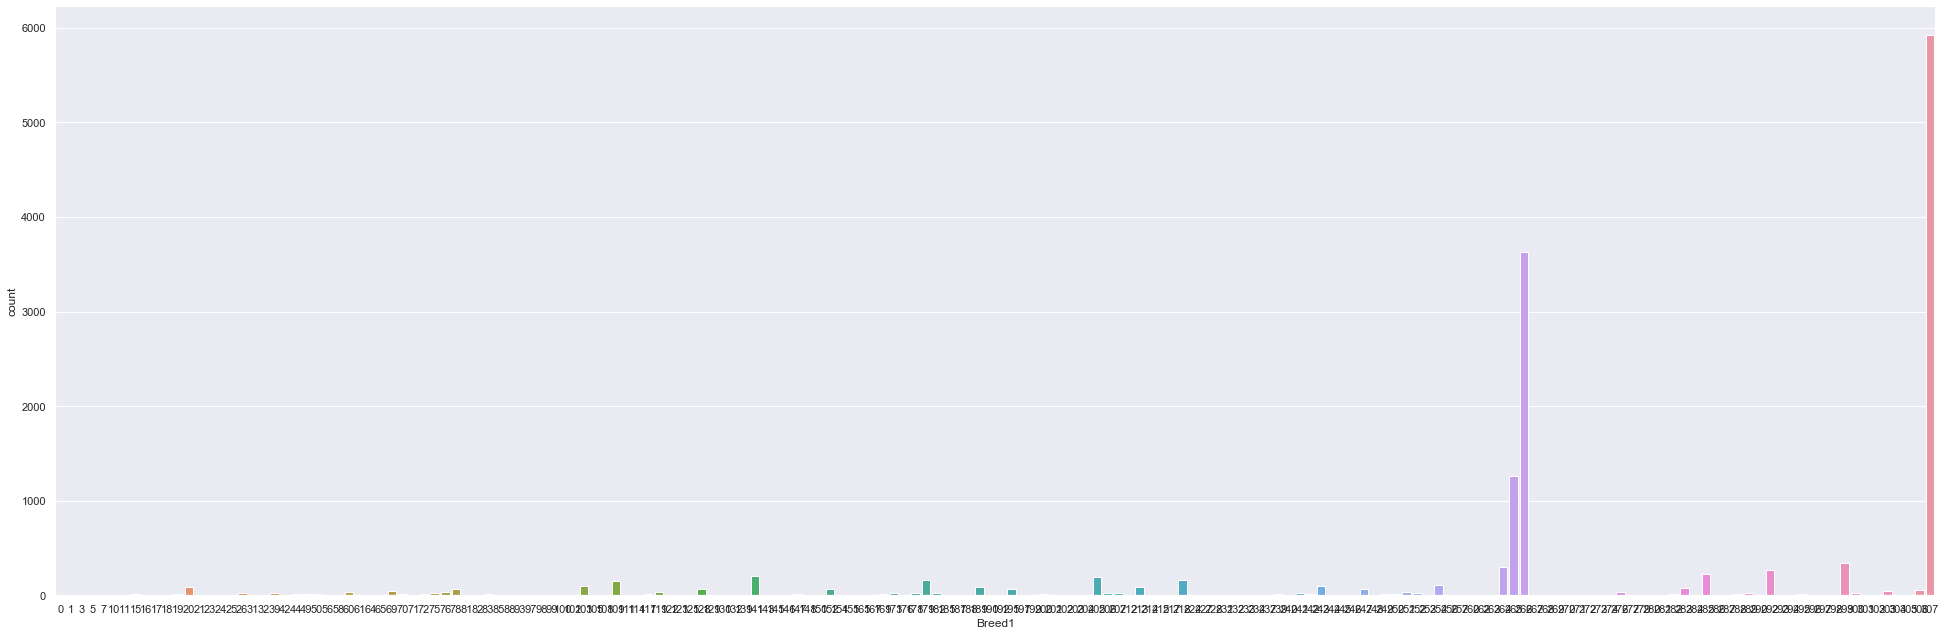

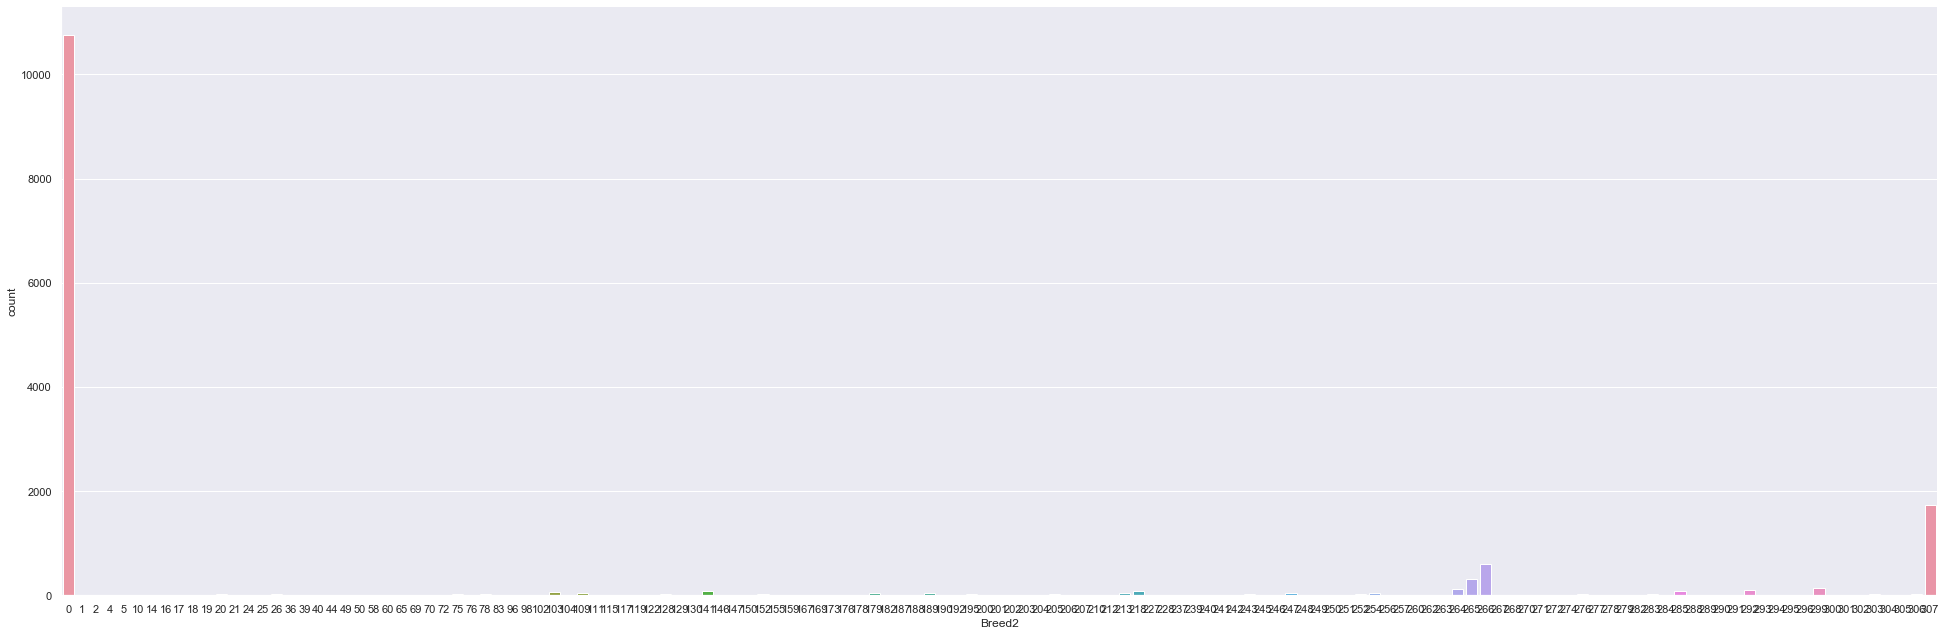

In [57]:
bx1 = sns.catplot(x="Breed1",data=df, kind='count',height=9, aspect=3)
bx2 = sns.catplot(x="Breed2",data=df, kind='count',height=9, aspect=3)

Looking at our data, and according to the breeds feature labels, we found some cats with dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds in which some breeds are poorly representated perhaps a good idea should be grouping pets by pure-race/mixed-race.

In [58]:
#Creating new feature: Pure breed
l3 =[]
for i in range(len(df)):
    if df['Breed1'][i]==307 or df['Breed2'][i]==307:
        l3.append(0)
    elif df['Breed1'][i]!=307 and df['Breed2'][i]==0:
        l3.append(1)
    elif df['Breed1'][i]==0 and df['Breed2'][i]!=307:
        l3.append(1)
    elif df['Breed1'][i]==df['Breed2'][i]:
        l3.append(1)
    else:
        l3.append(0)
        
df_processed2.drop("Breed1",axis=1,inplace=True)
df_processed2.drop("Breed2",axis=1,inplace=True) 
df_processed2.insert(3,'PureBreed',l3) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1
0,nan,nan
1,-3.85362,3.49515
2,15.5367,-12.8427
3,25.9202,-25.3278
4,23.972,-22.3732


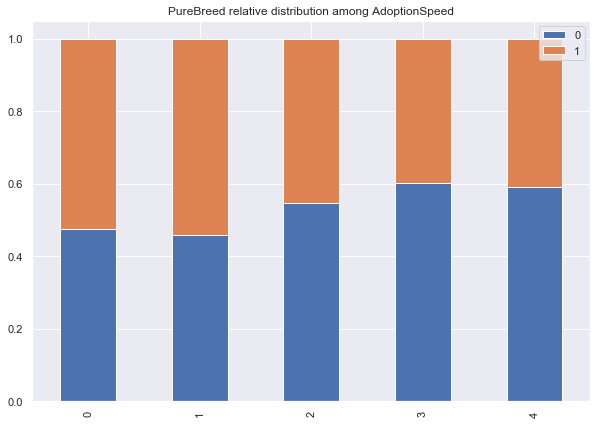

In [59]:
cat_distr_pairwise('AdoptionSpeed','PureBreed', df_processed2, frel=True)

From the plot and relative gain table we conclude that pure breed animals (1) tend to be adopted earlier, whereas mixed breed animals (0) are adopted later.

### Quantity

Number of pets represented in profile

There are 11565 profiles with a single pet
There are 3428 profiles with multiple pets


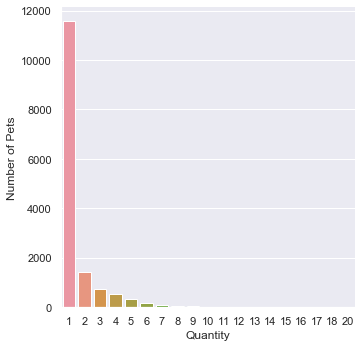

In [60]:
ax3 = sns.catplot(x='Quantity', data=df, kind='count')
(ax3.set_axis_labels("Quantity", "Number of Pets"))
print('There are {} profiles with a single pet'.format((list(df['Quantity'])).count(1)))
print('There are {} profiles with multiple pets'.format(len(df['Quantity'])-list(list(df['Quantity'])).count(1)))

Relative gain from AdoptionSpeed=0 (%):


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,-2.2292,9.9399,4.82201,8.19019,-20.3883,284.79,inf,-53.5599,inf,-73.4628,nan,nan,nan,nan,inf,nan,nan,nan,inf
2,-2.96626,5.48541,-7.49382,1.34035,43.6302,319.398,inf,10.4587,inf,-58.6498,inf,inf,inf,nan,inf,inf,inf,nan,inf
3,-3.02246,10.5374,-6.20593,-5.51533,33.0936,311.695,inf,9.55656,inf,-76.0682,inf,inf,inf,nan,inf,inf,inf,nan,inf
4,-9.30609,18.7931,8.69613,43.3819,87.2003,346.562,inf,13.0908,inf,251.011,inf,inf,inf,inf,inf,inf,inf,inf,inf


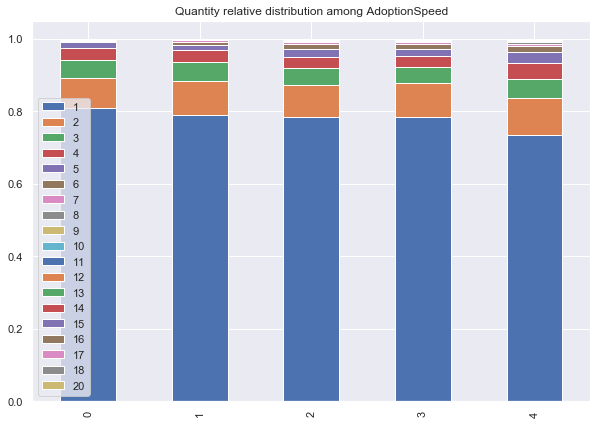

In [61]:
ste = cat_distr_pairwise('AdoptionSpeed','Quantity', df, frel=True)

The "inf" values on the table indicate that there are no examples of a pet with AdoptionSpeed=0 for that feature instance. Therefore, all positive relative gains are 'infinite'.

We can conclude that adds containing more than 5 pets could be more likely to be ignored, since those pets are adopted after a long time.

### Fee

After observing the fees distribution we considered 4 categories: 
* Free => 0
* Tens => 1
* Hundreds => 2
* Thousands => 3


In [62]:
f=[]
for i in df["Fee"]:
    if i==0:
        f.append(0)
    elif i<100:
        f.append(1)
    elif i<1000:
        f.append(2)
    else:
        f.append(3)

df_processed2.drop("Fee",axis=1,inplace=True) 
df_processed2.insert(4,'Free',f) ##INSERT IN DATAFRAME

Relative gain from AdoptionSpeed=0 (%):


,0,1,2,3
0,nan,nan,nan,nan
1,-2.95704,50.5987,3.661,-73.4628
2,-2.40591,45.0117,3.16559,-96.9208
3,-1.68287,41.4552,-1.16684,-134.985
4,-4.90487,54.3693,23.8168,-234.985


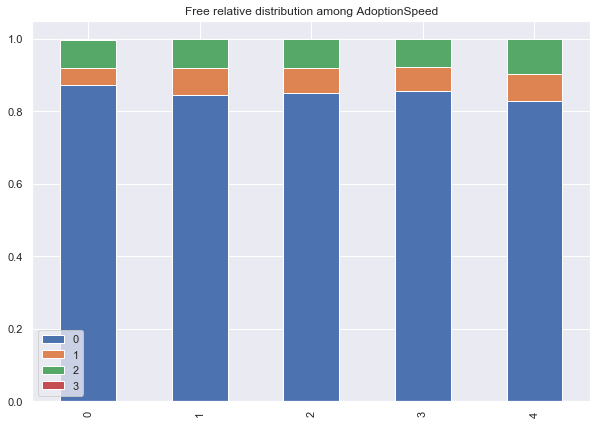

In [63]:
fee = cat_distr_pairwise('AdoptionSpeed','Free', df_processed2, frel=True)

It seems that pets with fees in the order of the thousands are less likely to be adopted fast.

### RescuerID

In order to extract some meaning from the 'RescuerID', we decided to create a new feature "FrequentRescuer" which indicates whether it is frequent for rescuers to save and advertise pets.

There are 5595 total rescuers in the dataset
There are 3783 rescuers with only 1 webpage entry in the dataset
There are 1812 rescuers with more than 1 webpage entry in the dataset


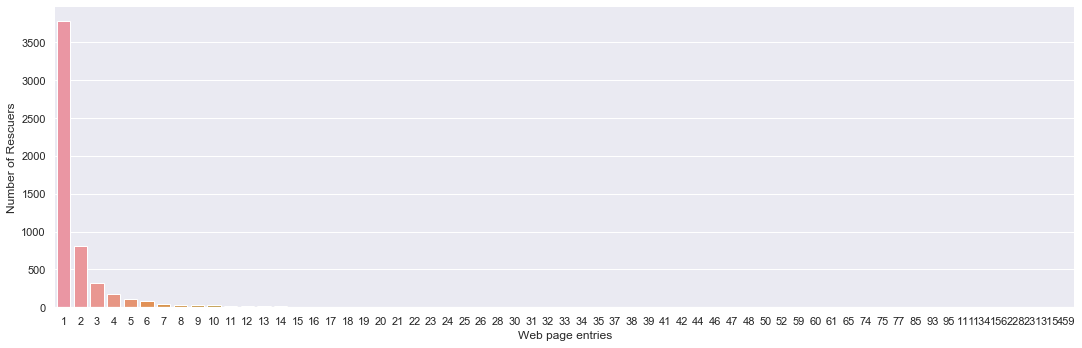

In [64]:
x = list(df['RescuerID'].unique())
y = list(df['RescuerID'])
z = []
t = {}
for i in x:
    z.append(y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} total rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Web page entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

According to the dataset, the number of rescuers with a single entry in the MyPet webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover whether the number of webpage profile entries associated with a rescuer has any interference in pet's apoption or adoption speed.

In [65]:
#CREATE NEW FEATURE FREQUENTRESCUER

lista2 = []
y = list(df['RescuerID'])
for i in df['RescuerID']:
      if y.count(i)>1:
          lista2.append(float(1))
      else:
          lista2.append(float(0))
          
df_processed1.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed1.drop("RescuerID", axis=1, inplace=True)

df_processed2.insert((df.columns.get_loc("RescuerID"))+1,'FrequentRescuer',lista2) ##INSERT IN DATAFRAME
df_processed2.drop("RescuerID", axis=1, inplace=True)

### VideoAmt

There are 14419 profiles with 0 videos
There are 574 profiles with more than 0 videos


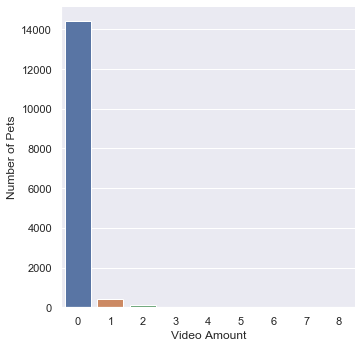

In [66]:
ax2 = sns.catplot(x='VideoAmt', data=df, kind='count')
(ax2.set_axis_labels("Video Amount", "Number of Pets"))
print('There are {} profiles with 0 videos'.format((list(df['VideoAmt'])).count(0)))
print('There are {} profiles with more than 0 videos'.format(len(df['VideoAmt'])-list(list(df['VideoAmt'])).count(0)))

Given the distribution of pets, we will consider this feature as binary: has Video (1) or does not have Video (0).

In [67]:
hasVideo=[]

for v in df['VideoAmt']:
    if v==0:
        hasVideo.append(0)
    else:
        hasVideo.append(1)
        
df_processed2.drop("VideoAmt", axis=1,inplace=True)
df_processed2.insert(5,"hasVideo",hasVideo) ##INSERT IN DATAFRAME

### Description

In order to extract some meaning from the 'Description', we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (size=0) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization procces.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium' size description is. In that sense, a 'medium' sized description would have the average word count. In analogy, the smallest and largest descriptions would correspond to the first and third quantiles.

The average descripton size: 62.953645034349364
According to this discretization, the bin edges should be:
[array([   0.,   28.,   65., 1257.])]


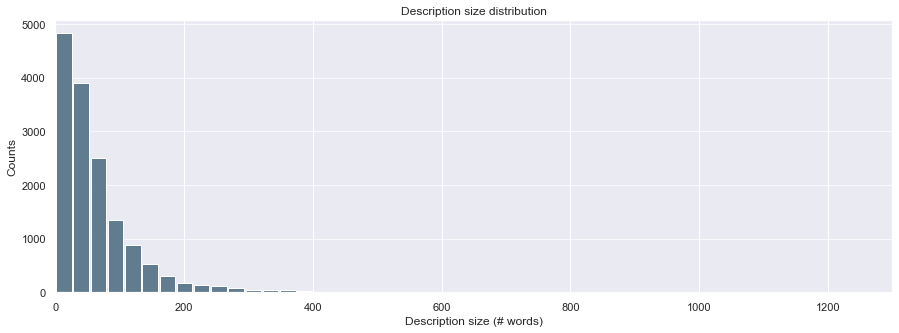

In [68]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.xlim([0.0,1300])

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* 'Empty' for descriptions containing 0 words => 0
* 'Small' for descriptions containing 1-28 words => 1
* 'Medium' for descriptions containing 29-65 words => 2
* 'Large' for descriptions containing 66-1257 words => 3

In [69]:
#Create new feature 'Description size'
d = []

for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        d.append(0)
    else:
        a= len(i.split())
        if a<29:
            d.append(1)
        elif a<66:
            d.append(2)
        else:
            d.append(3)
         
df_processed1.drop("Description", axis=1, inplace=True)
df_processed1.insert(6,"DescriptionSize",l) ##INSERT IN DATAFRAME

df_processed2.drop("Description", axis=1, inplace=True)
df_processed2.insert(6,"DescriptionSize",d) ##INSERT IN DATAFRAME

### Other conclusions
* Pets with maturity size 'Small' (1) and 'Extra Large'(4) are less likely to be in the adoption centre for a very long time (-45.0552% and -97.3772 of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1, respectively). 
* Pets with long fur(3) very rarely stay at the adoption centre for a long time (-116.814% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1).
* Sterilized pets tend to be adopted later (+82.13% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1).
* Pets with serious injuries (Health=3) are very more likely to be adopted after a long time, or not adopted at all (+182.091% of pets at AdoptionSpeed=4 relatively to AdoptionSpeed=1). 
* No pets were adopted in the same day having the add not provide a description!
* There was no clear evidence that the distribution of the features values among AdoptionSpeed classes was biased for features Gender, Vaccinated, Dewormed, States, FrequentRescuer.

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

## 1.1. Preprocessing Data for Classification

During our EDA we already preprocessed some of the features, for data visualization purposes. The result are two datasets:
* **df_processed1**: which we will use to benchmark the models' performance without the discretization of features discussed earlier, since they can remove the fine grain information that might be beneficial to the learning proccess. Some data cleaning was done, namely in features PetID, Name, RescuerID and DescriptionSize (in words, instead of text Description).

* **df_processed2**: which is the data set with the derived features and data cleaning. We will see if the dicretization will be helpful for the models or not.

### Features impact

Now that we have preprocessed our features, one way to determine the impact of each one on prediction models is to apply a random forest. Based on that information, we will  discard some features that have low impact and are probably causing noise.

Bellow we have a function that will apply a random forest model to any data set.
Code obtained from: <https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e>

In [70]:
from sklearn.ensemble import RandomForestClassifier 

def random_forest(df_x, df_y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=12)
  rf = RandomForestClassifier() 
  rf.fit(X_train, y_train) 
  score = rf.score(X_test, y_test)
  feature_importance = pd.DataFrame(rf.feature_importances_, index = df_x.columns, columns=['importance']).sort_values('importance',ascending=False).reset_index().rename(columns = {'index':'column'})
  return score, feature_importance

Original features importance (df_processed1):

In [71]:
score1, feature_importances1 = random_forest(
    df_processed1[df_processed1.columns.difference(['AdoptionSpeed'])],
    df_processed1['AdoptionSpeed'],
    0.2)
print("Score: ",score1)
print(feature_importances1)

/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score:  0.3841280426808936
             column  importance
0   DescriptionSize    0.157028
1          PhotoAmt    0.102069
2               Age    0.096911
3            Breed1    0.068873
4            Color2    0.063528
5            Color1    0.061751
6             State    0.053314
7            Breed2    0.043538
8            Gender    0.039533
9         FurLength    0.036950
10     MaturitySize    0.034230
11         Quantity    0.033384
12              Fee    0.032563
13         Dewormed    0.029810
14           Color3    0.029311
15       Vaccinated    0.027829
16       Sterilized    0.025082
17  FrequentRescuer    0.021209
18          hasName    0.016151
19             Type    0.010363
20         VideoAmt    0.009455
21           Health    0.007118


Extracted features importance :

In [72]:
score2, feature_importances2 = random_forest(
    df_processed2[df_processed2.columns.difference(['AdoptionSpeed'])], 
    df_processed2['AdoptionSpeed'],
    0.2)

print("Score: ",score2) 
print(feature_importances2)

/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Score:  0.35578526175391795
             column  importance
0          PhotoAmt    0.155209
1            Color1    0.093285
2            Color2    0.091534
3             State    0.072756
4   DescriptionSize    0.071771
5            Gender    0.055516
6         FurLength    0.052980
7          Quantity    0.046290
8            Color3    0.043691
9      MaturitySize    0.042336
10         Dewormed    0.041271
11       Vaccinated    0.038143
12             Free    0.036049
13       Sterilized    0.033261
14         AgeGroup    0.024360
15  FrequentRescuer    0.022298
16          hasName    0.021599
17        PureBreed    0.018405
18             Type    0.017735
19         hasVideo    0.011275
20           Health    0.010234


We conclude that, after our feature extractions, some features are actually contributing less to the model then they were before:
* DescriptionSize-in bins (DescriptionSize- nr. words)
* AgeGroup (Age)
* PureBreed (Breed1, Breed2)

We will go back to the original features in the classifiers analysis.
Some are doing slightly better/did not get worse so we will keep the changes:
* hasVideo (VideoAmt)
* Free (Fee)

In [73]:
#APPLY CHANGES TO DATASET - REVERT TO ORIGINAL FEATURES
#Description
df_processed2.drop("DescriptionSize", axis=1, inplace=True)
df_processed2.insert(6,"DescriptionSize",df_processed1['DescriptionSize'])

#AgeGroup
df_processed2.drop("AgeGroup", axis=1, inplace = True)
df_processed2.insert(2,"Age",df_processed1['Age'])

#PureBreed
df_processed2.drop("PureBreed", axis=1, inplace=True)
df_processed2.insert(6,"Breed1",df_processed1['Breed1'])
df_processed2.insert(6,"Breed2",df_processed1['Breed2'])

### Data imbalancement

As we explained in the beggining there is a clear imbalancement in the number of examples:
- Binary classification: the number of examples of AdoptionSpeed 0+1+2+3 (Adopted) is much greater than the number of examples for AdoptionSpeed 4 (Not Adopted).
- Multiclass classification: the number of examples of AdoptionSpeed 0 is much smaller than the rest of the Adoption Speeds.

Since we are working with such a small dataset, we cannot spare any examples, and we will resort to random oversampling to balance our data.

#### Binary Classification - Random Over-Sampling

In [103]:
#ADAPT TARGET COLUMN FOR BINARY CLASSIFICATION
df_processed2_b = df_processed2.copy()
df_processed2_b = df_processed2_b.rename(columns={'AdoptionSpeed': 'Adoption'})
df_processed2_b = df_processed2_b.replace({'Adoption':[0,2,3]},1)
df_processed2_b = df_processed2_b.replace({'Adoption':4},0)

In [118]:
#RANDOM OVERSAMPLING
ros_b = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_ros_b, y_ros_b = ros_b.fit_resample(df_processed2_b.iloc[:,:-1], df_processed2_b['Adoption'])
y_ros_b.shape = (21592,1) #reshape array for concatenation
np_processed2_b_balanced = np.concatenate((X_ros_b, y_ros_b), axis=1) #save new data

# Create new df
df_processed2_b_balanced = pd.DataFrame(data=np_processed2_b_balanced, columns=df_processed2_b.columns)

We can see that the oversampling was succesfull because we now have the same number of examples for adopted and not adopted pets, with a total of 21592 examples.

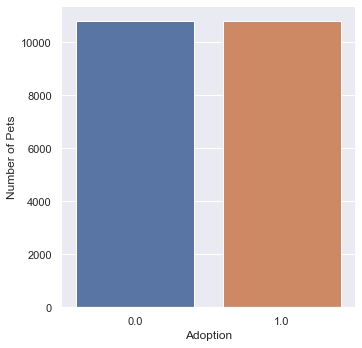

In [121]:
ax = sns.catplot(x="Adoption",data=df_processed2_b_balanced, kind='count')
(ax.set_axis_labels("Adoption", "Number of Pets"))

#### Multiclass classification - Random Over-Sampling

In [135]:
#RANDOM OVERSAMPLING
df_processed2_m = df_processed2.copy()
ros_m2 = RandomOverSampler(random_state=42)
X_ros_m, y_ros_m = ros_m.fit_resample(df_processed2_m.iloc[:,:-1], df_processed2_m['AdoptionSpeed'])
y_ros_m.shape = (20985,1) #reshape array for concatenation
np_processed2_m_balanced = np.concatenate((X_ros_m, y_ros_m), axis=1) #save new data

# Create new df
df_processed2_m_balanced = pd.DataFrame(data=np_processed2_m_balanced, columns=df_processed2_m.columns)

We can see that the oversampling was succesfull because we now have the same number of examples for all Adoption Speeds, with a total of 20985 examples.

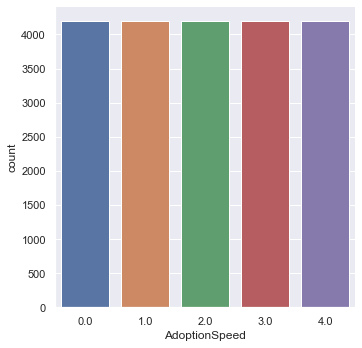

In [136]:
ax = sns.catplot(x="AdoptionSpeed",data=df_processed2_m_balanced, kind='count')

##### Dogs and Cats - preprocessing

In [149]:
# DOGS BINARY CLASSIFICATION
df_processed2_b_dogs = df_processed2_b_balanced.copy()
df_processed2_b_dogs = df_processed2_b_balanced[df_processed2_b_dogs['Type']==1]

# DOGS MULTICLASS CLASSIFICATION
df_processed2_m_dogs = df_processed2_m_balanced.copy()
df_processed2_m_dogs = df_processed2_m_dogs[df_processed2_m_dogs['Type']==1]

# CATS BINARY CLASSIFICATION
df_processed2_b_cats = df_processed2_b_balanced.copy()
df_processed2_b_cats = df_processed2_b_cats[df_processed2_b_cats['Type']==2]

# CATS MULTICLASS CLASSIFICATION
df_processed2_m_cats = df_processed2_m_balanced.copy()
df_processed2_m_cats = df_processed2_m_cats[df_processed2_m_cats['Type']==2]

### Pre-processing: final dataset
We have the following dataframes to be feed the classifiers in the following phase:
* Binary task: df_processed2_b_balanced
* Multiclass task: df_processed2_m_balanced
* Dogs binary task: df_processed2_b_dogs
* Dogs multiclass task: df_processed2_m_dogs
* Cats binary task: df_processed2_b_cats
* Cats multiclass task: df_processed2_m_cats

________________

## 1.2. Learning Classifiers

XXXXXXXXXX explicar estas funções

In [168]:
###### PRINT CONFUSION MATRIXES
def confusion (y_true,y_predict,x):
    cm = confusion_matrix(y_true, y_predict)
    y = np.unique(y_true)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(cm.T, cmap="coolwarm", square=True, annot = True, fmt='d', cbar=False,
                xticklabels=(y),
                yticklabels=(y))
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.title('Confusion Matrix - {} Set'.format(x))
    
    if len(y)==2:
        tn, fp, fn, tp = cm.ravel()
        print("True Negatives:{}".format(tn))
        print("False Positives:{}".format(fp))
        print("False Negatives:{}".format(fn))
        print("True Positives:{}".format(tp))
    else:
        print("Not binary")

In [169]:
####### PRINT DATASET STATUS
def set_dist (y,x):
    print("{}".format(x))
    for i in np.unique(y):
        print("{}: {}".format(i,np.count_nonzero(y == i)))

In [170]:
###### MODEL PIPELINE
def model (intro,xtrain,ytrain,xtest,ytest,model):
    print ("{}\n".format(intro))
    md = model.fit(xtrain,ytrain)
    print("Accuracy on training set:\n")
    trainscore = md.score(xtrain, ytrain)
    print("{}\n".format(trainscore))
    ytrainp = md.predict(xtrain)
    print('Classification report (train):')
    print(classification_report(ytrain,ytrainp))
    print("Accuracy on test set:\n") 
    testscore = md.score(xtest, ytest)
    print("{}\n".format(testscore))
    ytestp = md.predict(xtest)
    print('Classification report (test):')
    print(classification_report(ytest,ytestp))
    return ytrainp, ytestp, trainscore, testscore

## 1.2.1 Benchmark
Before going into training the classifiers with our altered datasets, we want to perform a benchmark of the original dataset's performance in the models (df_processed1).

#### FEATURE ENCODING

In [156]:
# ENCODING THE FOLLOWING FEATURES
## 'Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_processed1[['Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name = encoder.get_feature_names(['Type','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
df_processed1_encoded =  pd.DataFrame(df_encoded, columns= column_name)

print("A sample of the encoded features names: ", column_name[:10])

A sample of the encoded features names:  ['Type_1.0' 'Type_2.0' 'Breed1_0.0' 'Breed1_1.0' 'Breed1_3.0' 'Breed1_5.0'
 'Breed1_7.0' 'Breed1_10.0' 'Breed1_11.0' 'Breed1_15.0']


/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [157]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
df_processed1_encoded.insert(0,'PetID',df_processed1.index.tolist()) ## PetID
df_processed1_encoded.set_index("PetID", inplace=True) # change index to PetId
df_processed1_encoded.insert(2,'hasName',df_processed1['hasName']) ## hasName  
df_processed1_encoded.insert(3,'Age',df_processed1['Age']) ## AGE  
df_processed1_encoded.insert(4,'DescriptionSize',df_processed1['DescriptionSize']) ## DescriptionSize  
df_processed1_encoded.insert(5,'Quantity',df_processed1['Quantity']) ## QUANTITY    
df_processed1_encoded.insert(6,'Fee',df_processed1['Fee']) ## FEE  
df_processed1_encoded.insert(7,'FrequentRescuer',df_processed1['FrequentRescuer']) ## FrequentRescuer  
df_processed1_encoded.insert(8,'VideoAmt',df_processed1['VideoAmt']) ## VideoAmt  
df_processed1_encoded.insert(9,'PhotoAmt',df_processed1['PhotoAmt']) ## PhotoAmt
df_processed1_encoded.insert((len(df_processed1_encoded.columns)),'AdoptionSpeed',df_processed1['AdoptionSpeed']) ## AdoptionSpeed

In [158]:
# SEPARATE EXAMPLES FROM TARGETS
nc = df_processed1_encoded.shape[1]
matrix = df_processed1_encoded.values # Convert dataframe to darray
examples = matrix [:, 0:nc-1] # get features 
target = matrix [:, nc-1] # get class (last columns)           
fnames = df_processed1_encoded.columns.values[0:nc-1] #get features names
tname = df_processed1_encoded.columns.values[nc-1] #get target name

examples = examples.astype(float)
target = target.astype(float)

In [160]:
# SPLIT DATAFRAME INTO TEST AND TRAIN SETS
X_train, X_test, y_train, y_test = train_test_split(examples, target, random_state=0)

print("Number of examples and features for the train dataset: ", X_train.shape)
print("Number of examples and features for the test dataset: ", X_test.shape)

Number of examples and features for the train dataset:  (11244, 377)
Number of examples and features for the test dataset:  (3749, 377)


### 1.2.1.1 Predicting Adoption (binary classification task)

Since this is a binary task, the adoptionspeed had to be converted into a binary feature (0 - for profiles with adoptionspeed = 4; 1 for profiles with adoptionspeed < 4)

In [162]:
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()

for i in range(len(y_train_binary)):
    if y_train_binary[i]<4:
        y_train_binary[i]=1
    else:
        y_train_binary[i]=0

for i in range(len(y_test_binary)):
    if y_test_binary[i]<4:
        y_test_binary[i]=1
    else:
        y_test_binary[i]=0

In [163]:
print("Number of positives cases in the train set is: {}".format(np.count_nonzero(y_train_binary == 1)))
print("Number of negative cases in the train set is: {}".format(np.count_nonzero(y_train_binary == 0)))
print("Ratio positive to negative cases in the training set: {}".format((np.count_nonzero(y_train_binary == 1))/(np.count_nonzero(y_train_binary == 0))))

Number of positives cases in the train set is: 8078
Number of negative cases in the train set is: 3166
Ratio positive to negative cases in the training set: 2.5514845230574856


#### KNN

In [164]:
knn_b = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_b

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [165]:
y_train_pred_b_knn, y_test_pred_b_knn, trainscore_b_knn, testscore_b_knn = model('KNN',X_train,y_train_binary,X_test,y_test_binary,knn_b)

KNN

Accuracy on training set:

0.8332443970117396

Classification report (train):
              precision    recall  f1-score   support

         0.0       0.76      0.59      0.67      3166
         1.0       0.85      0.93      0.89      8078

    accuracy                           0.83     11244
   macro avg       0.81      0.76      0.78     11244
weighted avg       0.83      0.83      0.83     11244

Accuracy on test set:

0.6929847959455855

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.42      0.31      0.36      1031
         1.0       0.76      0.84      0.80      2718

    accuracy                           0.69      3749
   macro avg       0.59      0.57      0.58      3749
weighted avg       0.67      0.69      0.68      3749



True Negatives:1866
False Positives:1300
False Negatives:575
True Positives:7503


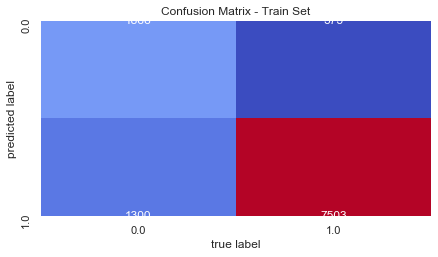

In [171]:
confusion (y_train_binary,y_train_pred_b_knn,'Train')

True Negatives:322
False Positives:709
False Negatives:442
True Positives:2276


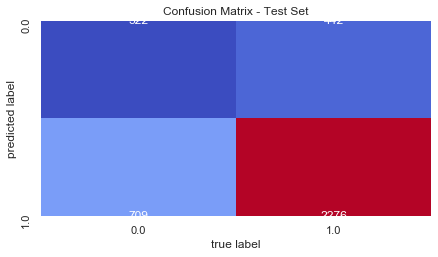

In [172]:
confusion (y_test_binary,y_test_pred_b_knn,'Test')

#### NAIVE BAYES

In [173]:
gnb_b = GaussianNB()
gnb_b

GaussianNB(priors=None, var_smoothing=1e-09)

In [174]:
y_train_pred_b_GNB, y_test_pred_b_GNB, trainscore_b_GNB, testscore_b_GNB = model('GNB',X_train,y_train_binary,X_test,y_test_binary,gnb_b)

GNB

Accuracy on training set:

0.3468516542155816

Classification report (train):
              precision    recall  f1-score   support

         0.0       0.30      0.97      0.46      3166
         1.0       0.90      0.10      0.18      8078

    accuracy                           0.35     11244
   macro avg       0.60      0.54      0.32     11244
weighted avg       0.73      0.35      0.26     11244

Accuracy on test set:

0.32088556948519603

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.28      0.96      0.44      1031
         1.0       0.84      0.08      0.14      2718

    accuracy                           0.32      3749
   macro avg       0.56      0.52      0.29      3749
weighted avg       0.69      0.32      0.22      3749



True Negatives:3075
False Positives:91
False Negatives:7253
True Positives:825


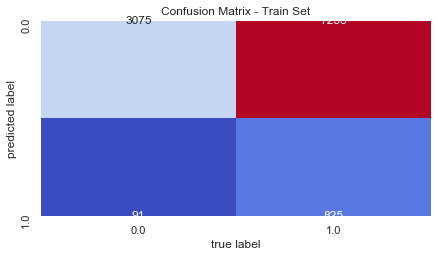

In [175]:
confusion (y_train_binary,y_train_pred_b_GNB,'Train')

True Negatives:990
False Positives:41
False Negatives:2505
True Positives:213


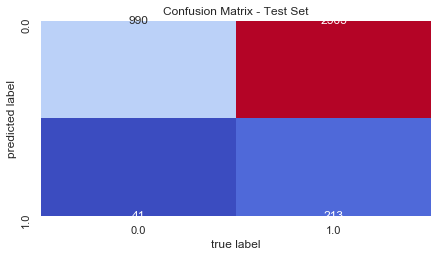

In [176]:
confusion (y_test_binary,y_test_pred_b_GNB,'Test')

#### DECISION TREES

In [177]:
dec_trees_b = tree.DecisionTreeClassifier() # criterion = "Gini"

dec_trees_b

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [178]:
y_train_pred_b_trees, y_test_pred_b_trees, trainscore_b_trees, testscore_b_trees = model('DECISION TREES',X_train,y_train_binary,X_test,y_test_binary,dec_trees_b)

DECISION TREES

Accuracy on training set:

0.9997331910352187

Classification report (train):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3166
         1.0       1.00      1.00      1.00      8078

    accuracy                           1.00     11244
   macro avg       1.00      1.00      1.00     11244
weighted avg       1.00      1.00      1.00     11244

Accuracy on test set:

0.6937850093358229

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.45      0.49      0.47      1031
         1.0       0.80      0.77      0.79      2718

    accuracy                           0.69      3749
   macro avg       0.62      0.63      0.63      3749
weighted avg       0.70      0.69      0.70      3749



True Negatives:3166
False Positives:0
False Negatives:3
True Positives:8075


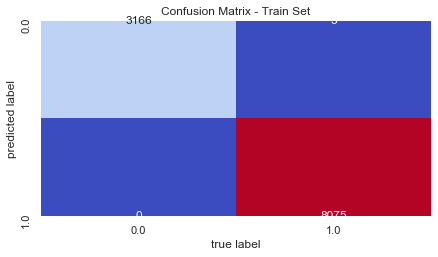

In [179]:
confusion (y_train_binary,y_train_pred_b_trees,'Train')

True Negatives:502
False Positives:529
False Negatives:619
True Positives:2099


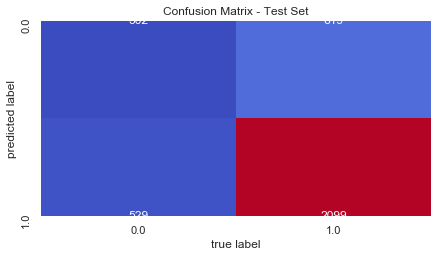

In [180]:
confusion (y_test_binary,y_test_pred_b_trees,'Test')

#### Support Vector Machines

In [181]:
lsvm_b = LinearSVC(max_iter=15000) # max_iter=1000 (default) ## Didnt converge
lsvm_b

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=15000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [182]:
y_train_pred_b_svm, y_test_pred_b_svm, trainscore_b_svm, testscore_b_svm = model('Support Vector Machine',X_train,y_train_binary,X_test,y_test_binary,lsvm_b)

Support Vector Machine

Accuracy on training set:

0.7317680540732835

Classification report (train):
              precision    recall  f1-score   support

         0.0       0.53      0.45      0.49      3166
         1.0       0.80      0.84      0.82      8078

    accuracy                           0.73     11244
   macro avg       0.66      0.65      0.65     11244
weighted avg       0.72      0.73      0.72     11244

Accuracy on test set:

0.7132568684982662

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.48      0.41      0.44      1031
         1.0       0.79      0.83      0.81      2718

    accuracy                           0.71      3749
   macro avg       0.63      0.62      0.62      3749
weighted avg       0.70      0.71      0.71      3749



/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


True Negatives:1424
False Positives:1742
False Negatives:1274
True Positives:6804


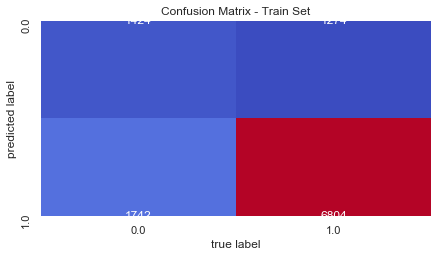

In [185]:
confusion (y_train_binary,y_train_pred_b_svm,'Train')

True Negatives:427
False Positives:604
False Negatives:471
True Positives:2247


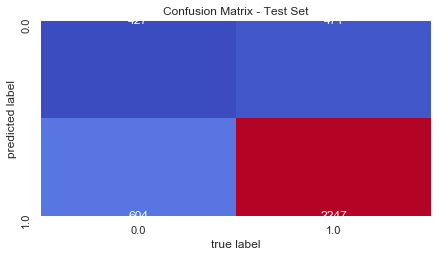

In [186]:
confusion (y_test_binary,y_test_pred_b_svm,'Test')

#### Logistic Regression

In [187]:
logreg_b = LogisticRegression(solver='lbfgs', max_iter=4000)
logreg_b

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [188]:
y_train_pred_b_logr, y_test_pred_b_logr, trainscore_b_logr, testscore_b_logr = model('Logistic Regression',X_train,y_train_binary,X_test,y_test_binary,logreg_b)

Logistic Regression

Accuracy on training set:

0.7583600142298115

Classification report (train):
              precision    recall  f1-score   support

         0.0       0.64      0.32      0.42      3166
         1.0       0.78      0.93      0.85      8078

    accuracy                           0.76     11244
   macro avg       0.71      0.62      0.64     11244
weighted avg       0.74      0.76      0.73     11244

Accuracy on test set:

0.7423312883435583

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.56      0.28      0.37      1031
         1.0       0.77      0.92      0.84      2718

    accuracy                           0.74      3749
   macro avg       0.67      0.60      0.61      3749
weighted avg       0.71      0.74      0.71      3749



True Negatives:999
False Positives:2167
False Negatives:550
True Positives:7528


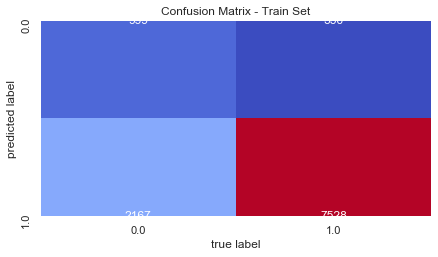

In [189]:
confusion (y_train_binary,y_train_pred_b_logr,'Train')

True Negatives:288
False Positives:743
False Negatives:223
True Positives:2495


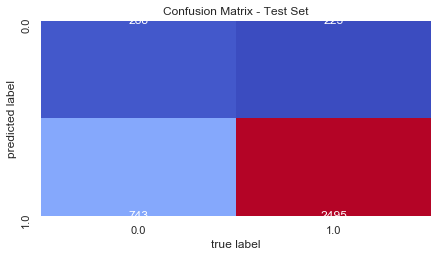

In [191]:
confusion (y_test_binary,y_test_pred_b_logr,'Test')

Given these results we conclude that:
* 

### 1.2.1.2 Predicting AdoptionSpeed (Multiclass classification task)

In [ ]:
set_dist(y_train,'Adoption Speed - Train Set')

In [ ]:
set_dist(y_test,'Adoption Speed - Test Set')

#### KNN

In [ ]:
knn_m = neighbors.KNeighborsClassifier(n_neighbors=3) ## 3 neighbors for starters
knn_m

In [ ]:
y_train_pred_m_KNN, y_test_pred_m_KNN, trainscore_m_knn, testscore_m_knn = model('KNN',X_train,y_train,X_test,y_test,knn_m)

In [ ]:
confusion (y_train,y_train_pred_m_KNN,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_KNN,'Test')

#### NAIVE BAYES

In [ ]:
gnb_m = GaussianNB()
gnb_m

In [ ]:
y_train_pred_m_GBN, y_test_pred_m_GBB, trainscore_m_gnb, testscore_m_gnb = model('GNB',X_train,y_train,X_test,y_test,gnb_m)

In [ ]:
confusion (y_train,y_train_pred_m_GBN,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_GBB,'Test')

#### DECISION TREES

In [ ]:
dec_trees_m = tree.DecisionTreeClassifier() # criterion = "Gini"

dec_trees_m

In [ ]:
y_train_pred_m_trees, y_test_pred_m_trees, trainscore_m_trees, testscore_m_trees = model('DECISION TREES',X_train,y_train,X_test,y_test,dec_trees_m)

In [ ]:
confusion (y_train,y_train_pred_m_trees,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_trees,'Test')

#### SUPPORT VECTOR MACHINES

In [ ]:
lsvm_m = LinearSVC(max_iter=15000) # max_iter=1000 (default) ## Didnt coverge
lsvm_m

In [ ]:
y_train_pred_m_svm, y_test_pred_m_svm, trainscore_m_svm, testscore_m_svm = model('Support Vector Machine',X_train,y_train,X_test,y_test,lsvm_m)

In [ ]:
confusion (y_train,y_train_pred_m_svm,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_svm,'Test')

#### LOGISTIC REGRESSION

In [ ]:
logreg_m = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg_m

In [ ]:
y_train_pred_m_logr, y_test_pred_m_logr, trainscore_m_logr, testscore_m_logr = model('Logistic Regression',X_train,y_train,X_test,y_test,logreg_m)

In [ ]:
confusion (y_train,y_train_pred_m_logr,'Train')

In [ ]:
confusion (y_test,y_test_pred_m_logr,'Test')

### Predicting pet-specific models

#### DOGS (Type 1)

In [ ]:
df_processed1_dogs = df_processed1.copy()
df_processed1_dogs = df_processed1_dogs[df_processed1_dogs['Type']==1]

##### Binary Classification

In [ ]:
# ENCODING THE FOLLOWING FEATURES
## 'Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'
encoder_dogs = OneHotEncoder()
df_encoded_dogs = encoder_dogs.fit_transform(df_processed1_dogs[['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name_dogs = encoder_dogs.get_feature_names(['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
df_processed1_dogs_encoded =  pd.DataFrame(df_encoded_dogs, columns= column_name_dogs)

print(column_name_dogs) #encoded features names

In [ ]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
df_processed1_dogs_encoded.insert(0,'PetID',df_processed1_dogs.index.tolist()) ## PetID
df_processed1_dogs_encoded.set_index("PetID", inplace=True) # change index to PetId
df_processed1_dogs_encoded.insert(2,'hasName',df_processed1_dogs['hasName']) ## hasName  
df_processed1_dogs_encoded.insert(3,'Age',df_processed1_dogs['Age']) ## AGE  
df_processed1_dogs_encoded.insert(4,'DescriptionSize',df_processed1_dogs['DescriptionSize']) ## DescriptionSize  
df_processed1_dogs_encoded.insert(5,'Quantity',df_processed1_dogs['Quantity']) ## QUANTITY    
df_processed1_dogs_encoded.insert(6,'Fee',df_processed1_dogs['Fee']) ## FEE  
df_processed1_dogs_encoded.insert(7,'FrequentRescuer',df_processed1_dogs['FrequentRescuer']) ## FrequentRescuer  
df_processed1_dogs_encoded.insert(8,'VideoAmt',df_processed1_dogs['VideoAmt']) ## VideoAmt  
df_processed1_dogs_encoded.insert(9,'PhotoAmt',df_processed1_dogs['PhotoAmt']) ## PhotoAmt
df_processed1_dogs_encoded.insert((len(df_processed1_dogs_encoded.columns)),'AdoptionSpeed',df_processed1_dogs['AdoptionSpeed']) ## AdoptionSpeed

print(df_processed1_dogs_encoded.columns.values) ## data frame for training

#### CATS (Type 1)

In [ ]:
df_processed1_cats = df_processed1.copy()

df_processed1_cats = df_processed1_cats[df_processed1_cats['Type']==2]

print(df_processed1_cats)

##### Binary Classification

In [ ]:
# ENCODING THE FOLLOWING FEATURES
## 'Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'
encoder_cats = OneHotEncoder()
df_encoded_cats = encoder_cats.fit_transform(df_processed1_cats[['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State']]).toarray()
column_name_cats = encoder_cats.get_feature_names(['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized','Health','State'])
df_processed1_cats_encoded =  pd.DataFrame(df_encoded_cats, columns= column_name_cats)

print(column_name_cats) #encoded features names

In [ ]:
# INSERT THE NON ENCODED FEATURES IN THE DATAFRAME AGAIN
df_processed1_cats_encoded.insert(0,'PetID',df_processed1_cats.index.tolist()) ## PetID
df_processed1_cats_encoded.set_index("PetID", inplace=True) # change index to PetId
df_processed1_cats_encoded.insert(2,'hasName',df_processed1_cats['hasName']) ## hasName  
df_processed1_cats_encoded.insert(3,'Age',df_processed1_cats['Age']) ## AGE  
df_processed1_cats_encoded.insert(4,'DescriptionSize',df_processed1_cats['DescriptionSize']) ## DescriptionSize  
df_processed1_cats_encoded.insert(5,'Quantity',df_processed1_cats['Quantity']) ## QUANTITY    
df_processed1_cats_encoded.insert(6,'Fee',df_processed1_cats['Fee']) ## FEE  
df_processed1_cats_encoded.insert(7,'FrequentRescuer',df_processed1_cats['FrequentRescuer']) ## FrequentRescuer  
df_processed1_cats_encoded.insert(8,'VideoAmt',df_processed1_cats['VideoAmt']) ## VideoAmt  
df_processed1_cats_encoded.insert(9,'PhotoAmt',df_processed1_cats['PhotoAmt']) ## PhotoAmt
df_processed1_cats_encoded.insert((len(df_processed1_cats_encoded.columns)),'AdoptionSpeed',df_processed1_cats['AdoptionSpeed']) ## AdoptionSpeed

print(df_processed1_cats_encoded.columns.values) ## data frame for training

## 1.2.2 Predicting Adoption (binary classification task)

## 1.2.3 Predicting Adoption Speed (Multiclass classification task)

## 1.2.4 Predicting Adoption/Adoption Speed for dogs

## 1.2.5 Predicting Adoption/Adoption Speed for cats

## 1.3. Classification - Results and Discussion 

## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

...

## 2.2. Finding Associations

...

## 2.3 Association Rules - Results and Discussion 

...

## 2.4. Preprocessing Data for Clustering

...

## 2.5. Finding Groups

...

## 2.6. Clustering - Results and Discussion 

...

## 3. Final Comments and Conclusions

...